In [1]:
!pip install --force-reinstall --no-deps numpy==1.26.4 scikit-learn==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 670.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 39.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


# Import and setup

In [2]:
!pip install ultralytics

import json, shutil, yaml, warnings, gc, random, math, copy, os
from pathlib import Path
from PIL import Image
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42); random.seed(42); np.random.seed(42)
torch.backends.cudnn.benchmark = True
print("Device:", device, "| torch", torch.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 17.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

# Paths

In [3]:
BASE  = Path("/kaggle/input/assignment-mango")
WORK  = Path("/kaggle/working/mango_ssl_v11")
SPLIT = WORK / "0_yolo_split"
DATA  = WORK / "data_mango.yaml"
SSL_W = WORK / "byol_backbone_with_hooks_yv11.pth"
PLOTS = WORK / "plots"
WORK.mkdir(parents=True, exist_ok=True)
PLOTS.mkdir(parents=True, exist_ok=True)

def get_detect_module(model_module):
    """Return the Detect head (robust across YOLO versions)."""
    try:
        last = model_module.model[-1]
        if "Detect" in last.__class__.__name__:
            return last
    except Exception:
        pass
    cand = None
    for m in model_module.modules():
        if "Detect" in m.__class__.__name__:
            cand = m
    return cand if cand is not None else list(model_module.modules())[-1]


# COCO → YOLO Conversion with train/val/test split

In [4]:
def coco2yolo(b, w, h):
    x, y, bw, bh = b
    return (x+bw/2)/w, (y+bh/2)/h, bw/w, bh/h

def convert_mango_coco_to_yolo():
    """Convert your 4 COCO folders to single YOLO dataset with train/val/test split"""

    if DATA.exists():
        print("YOLO split already exists")
        return

    print("Converting COCO → YOLO for mango dataset...")

    # Create output directories
    for split in ["train", "val", "test"]:
        (SPLIT / split / "images").mkdir(parents=True, exist_ok=True)
        (SPLIT / split / "labels").mkdir(parents=True, exist_ok=True)

    DATA_ROOT = BASE / "mango"

    # COCO annotation files for each class
    COCO_FILES = {
        "Early-Fruit": DATA_ROOT / "Annotation/Early-fruit/_annotations.coco.json",
        "Mature": DATA_ROOT / "Annotation/Mature/_annotations.coco.json",
        "Premature": DATA_ROOT / "Annotation/Premature/_annotations.coco.json",
        "Ripe": DATA_ROOT / "Annotation/Ripe/_annotations.coco.json"
    }

    # Image directories for each class
    IMG_DIRS = {
        "Early-Fruit": DATA_ROOT / "Early-Fruit_COCO",
        "Mature": DATA_ROOT / "Mature_COCO",
        "Premature": DATA_ROOT / "Premature_COCO",
        "Ripe": DATA_ROOT / "Ripe_COCO"
    }

    CLASSES = ["Early-Fruit", "Mature", "Premature", "Ripe"]
    class_to_id = {name: idx for idx, name in enumerate(CLASSES)}

    all_images = []

    # Process each COCO file
    for class_name, coco_file in COCO_FILES.items():
        if not coco_file.exists():
            print(f"Warning: {coco_file} not found, skipping {class_name}")
            continue

        print(f"Processing {class_name}...")

        with open(coco_file) as f:
            coco_data = json.load(f)

        image_id_to_info = {img["id"]: img for img in coco_data["images"]}

        # Group annotations by image
        image_annotations = {}
        for ann in coco_data["annotations"]:
            img_id = ann["image_id"]
            if img_id not in image_annotations:
                image_annotations[img_id] = []
            image_annotations[img_id].append(ann)

        # Process each image
        img_dir = IMG_DIRS[class_name]
        for img_id, img_info in image_id_to_info.items():
            img_filename = img_info["file_name"]
            img_path = img_dir / img_filename

            if not img_path.exists():
                continue

            # Convert annotations to YOLO format
            yolo_labels = []
            if img_id in image_annotations:
                for ann in image_annotations[img_id]:
                    bbox_yolo = coco2yolo(ann["bbox"], img_info["width"], img_info["height"])
                    class_id = class_to_id[class_name]
                    yolo_labels.append(f"{class_id} {' '.join(f'{v:.6f}' for v in bbox_yolo)}")

            label_content = "\n".join(yolo_labels)
            all_images.append((img_path, label_content, class_name))

    print(f"Total images collected: {len(all_images)}")

    # Stratified split: 80% train, 10% val, 10% test
    from sklearn.model_selection import train_test_split

    class_labels = [item[2] for item in all_images]
    indices = np.arange(len(all_images))

    # First split: 80% train, 20% temp (val+test)
    train_idx, temp_idx = train_test_split(
        indices, test_size=0.2, stratify=class_labels, random_state=42
    )

    # Second split: 10% val, 10% test (split the 20% temp)
    temp_labels = [class_labels[i] for i in temp_idx]
    val_idx, test_idx = train_test_split(
        temp_idx, test_size=0.5, stratify=temp_labels, random_state=42
    )

    # Copy files to respective splits
    splits = {
        "train": train_idx,
        "val": val_idx,
        "test": test_idx
    }

    for split_name, indices in splits.items():
        print(f"Copying {len(indices)} images to {split_name}...")

        for idx in tqdm(indices, desc=f"Processing {split_name}", leave=False):
            img_path, label_content, _ = all_images[idx]

            # Copy image
            dst_img = SPLIT / split_name / "images" / img_path.name
            shutil.copy(img_path, dst_img)

            # Write label file
            stem = img_path.stem
            dst_label = SPLIT / split_name / "labels" / f"{stem}.txt"
            with open(dst_label, "w") as f:
                f.write(label_content)

    # Create data.yaml
    yaml_content = {
        "path": str(SPLIT),
        "train": "train/images",
        "val": "val/images",
        "test": "test/images",
        "nc": len(CLASSES),
        "names": CLASSES
    }

    with open(DATA, "w") as f:
        yaml.dump(yaml_content, f)

    print("YOLO conversion complete!")
    print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")
    print(f"Data config saved to: {DATA}")

# Run the conversion
convert_mango_coco_to_yolo()

Converting COCO → YOLO for mango dataset...
Processing Early-Fruit...
Processing Mature...
Processing Premature...
Processing Ripe...
Total images collected: 2004
Copying 1603 images to train...


Processing train:   0%|          | 0/1603 [00:00<?, ?it/s]

Copying 200 images to val...


Processing val:   0%|          | 0/200 [00:00<?, ?it/s]

Copying 201 images to test...


Processing test:   0%|          | 0/201 [00:00<?, ?it/s]

YOLO conversion complete!
Train: 1603, Val: 200, Test: 201
Data config saved to: /kaggle/working/mango_ssl_v11/data_mango.yaml


# Two-view dataset for SSL

In [5]:
class TwoView(Dataset):
    SUPP = ('*.jpg','*.JPG','*.jpeg','*.JPEG','*.png','*.PNG','*.bmp','*.BMP','*.webp','*.WEBP')
    def __init__(self, roots, tfm):
        self.files=[]
        for r in roots:
            pr=Path(r)
            for p in self.SUPP:
                self.files.extend(pr.rglob(p))
        if not self.files: raise RuntimeError(f"No images found under {roots}")
        self.tfm=tfm
        print(f"Found {len(self.files)} images for SSL training")
    def __len__(self): return len(self.files)
    def __getitem__(self,idx):
        img=Image.open(self.files[idx]).convert("RGB")
        return self.tfm(img), self.tfm(img)

# Optimized augmentation for fruit/agricultural images
augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def byol_loss(p, z):
    p = F.normalize(p, dim=1)
    z = F.normalize(z, dim=1)
    return 2 - 2*(p*z).sum(dim=1).mean()

class DetectInputHook:
    def __init__(self, detect_module):
        self.handle = detect_module.register_forward_pre_hook(self.hook)
        self.feats = None
    def hook(self, module, inputs):
        self.feats = list(inputs[0])
        return None
    def close(self):
        self.handle.remove()

def global_pool_concat(feats):
    pooled = [F.adaptive_avg_pool2d(f, 1).flatten(1) for f in feats]
    return torch.cat(pooled, dim=1)


# BYOL pre-training with YOLOv11 backbone - 50+ epochs


BYOL pre-training (50 epochs, hook-based, YOLOv11n) …
Backbone feature dim: 448
Found 1803 images for SSL training
SSL Dataset: 1803 images, 112 batches per epoch


BYOL 1/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 1/50 | BYOL loss: 1.6071 | LR: 0.000999
New best loss: 1.6071 - saving checkpoint


BYOL 2/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2/50 | BYOL loss: 1.3470 | LR: 0.000996
New best loss: 1.3470 - saving checkpoint


BYOL 3/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 3/50 | BYOL loss: 1.2505 | LR: 0.000991
New best loss: 1.2505 - saving checkpoint


BYOL 4/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 4/50 | BYOL loss: 1.1912 | LR: 0.000984
New best loss: 1.1912 - saving checkpoint


BYOL 5/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 5/50 | BYOL loss: 1.1348 | LR: 0.000976
New best loss: 1.1348 - saving checkpoint


BYOL 6/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 6/50 | BYOL loss: 1.1353 | LR: 0.000965


BYOL 7/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 7/50 | BYOL loss: 1.1099 | LR: 0.000953
New best loss: 1.1099 - saving checkpoint


BYOL 8/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 8/50 | BYOL loss: 1.0287 | LR: 0.000939
New best loss: 1.0287 - saving checkpoint


BYOL 9/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 9/50 | BYOL loss: 1.0252 | LR: 0.000923
New best loss: 1.0252 - saving checkpoint


BYOL 10/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10/50 | BYOL loss: 0.9724 | LR: 0.000905
New best loss: 0.9724 - saving checkpoint


BYOL 11/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 11/50 | BYOL loss: 0.9373 | LR: 0.000886
New best loss: 0.9373 - saving checkpoint


BYOL 12/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 12/50 | BYOL loss: 0.8899 | LR: 0.000866
New best loss: 0.8899 - saving checkpoint


BYOL 13/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 13/50 | BYOL loss: 0.9088 | LR: 0.000844


BYOL 14/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 14/50 | BYOL loss: 0.8927 | LR: 0.000821


BYOL 15/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 15/50 | BYOL loss: 0.9099 | LR: 0.000796


BYOL 16/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 16/50 | BYOL loss: 0.8422 | LR: 0.000770
New best loss: 0.8422 - saving checkpoint


BYOL 17/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 17/50 | BYOL loss: 0.8569 | LR: 0.000743


BYOL 18/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 18/50 | BYOL loss: 0.8851 | LR: 0.000716


BYOL 19/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 19/50 | BYOL loss: 0.8584 | LR: 0.000687


BYOL 20/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():^
 ^ ^^ ^ ^ ^^

Epoch 20/50 | BYOL loss: 0.8094 | LR: 0.000658
New best loss: 0.8094 - saving checkpoint


BYOL 21/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 21/50 | BYOL loss: 0.8122 | LR: 0.000628


BYOL 22/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 22/50 | BYOL loss: 0.8242 | LR: 0.000598


BYOL 23/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 23/50 | BYOL loss: 0.8557 | LR: 0.000567


BYOL 24/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 24/50 | BYOL loss: 0.8314 | LR: 0.000536


BYOL 25/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 25/50 | BYOL loss: 0.8313 | LR: 0.000505


BYOL 26/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 26/50 | BYOL loss: 0.8534 | LR: 0.000474


BYOL 27/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 27/50 | BYOL loss: 0.8693 | LR: 0.000443


BYOL 28/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 28/50 | BYOL loss: 0.8410 | LR: 0.000412


BYOL 29/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 29/50 | BYOL loss: 0.8410 | LR: 0.000382


BYOL 30/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 30/50 | BYOL loss: 0.8054 | LR: 0.000352
New best loss: 0.8054 - saving checkpoint


BYOL 31/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 31/50 | BYOL loss: 0.8212 | LR: 0.000323


BYOL 32/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 32/50 | BYOL loss: 0.8209 | LR: 0.000294


BYOL 33/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 33/50 | BYOL loss: 0.8007 | LR: 0.000267
New best loss: 0.8007 - saving checkpoint


BYOL 34/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 34/50 | BYOL loss: 0.8018 | LR: 0.000240


BYOL 35/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 35/50 | BYOL loss: 0.8191 | LR: 0.000214


BYOL 36/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 36/50 | BYOL loss: 0.7926 | LR: 0.000189
New best loss: 0.7926 - saving checkpoint


BYOL 37/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 37/50 | BYOL loss: 0.7627 | LR: 0.000166
New best loss: 0.7627 - saving checkpoint


BYOL 38/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 38/50 | BYOL loss: 0.7688 | LR: 0.000144


BYOL 39/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 39/50 | BYOL loss: 0.7833 | LR: 0.000124


BYOL 40/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^if w.is_alive():^^
^^ ^ ^ ^^ ^ ^ ^ ^

Epoch 40/50 | BYOL loss: 0.7916 | LR: 0.000105


BYOL 41/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 41/50 | BYOL loss: 0.7441 | LR: 0.000087
New best loss: 0.7441 - saving checkpoint


BYOL 42/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 42/50 | BYOL loss: 0.7884 | LR: 0.000071


BYOL 43/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 43/50 | BYOL loss: 0.7825 | LR: 0.000057


BYOL 44/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 44/50 | BYOL loss: 0.7618 | LR: 0.000045


BYOL 45/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 45/50 | BYOL loss: 0.7649 | LR: 0.000034


BYOL 46/50:   0%|          | 0/112 [00:00<?, ?it/s]

Epoch 46/50 | BYOL loss: 0.7633 | LR: 0.000026


BYOL 47/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 47/50 | BYOL loss: 0.8090 | LR: 0.000019


BYOL 48/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 48/50 | BYOL loss: 0.7895 | LR: 0.000014


BYOL 49/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 49/50 | BYOL loss: 0.7628 | LR: 0.000011


BYOL 50/50:   0%|          | 0/112 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x798877b5d800>
    Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
if w.is_alive():    if w.is_alive():
 
             ^^^^^^^^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3

Epoch 50/50 | BYOL loss: 0.7838 | LR: 0.000010


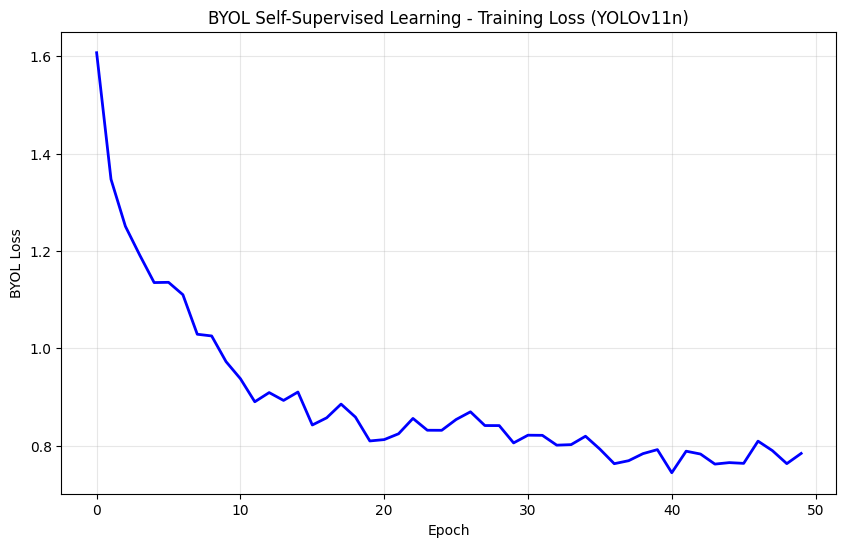

Saved SSL backbone weights → /kaggle/working/mango_ssl_v11/byol_backbone_with_hooks_yv11.pth
Final SSL best loss: 0.7441


In [6]:

MODEL = "yolo11n.pt"  # Changed from yolov10n.pt to yolov11n.pt
SSL_EPOCHS, SSL_BATCH = 50, 16
m0 = 0.996

if SSL_W.exists():
    print("BYOL backbone cached – skipping pre-train")
else:
    print(f"\nBYOL pre-training ({SSL_EPOCHS} epochs, hook-based, YOLOv11n) …")

    # Full models
    online_full = YOLO(MODEL).model.to(device)
    target_full = YOLO(MODEL).model.to(device)
    target_full.load_state_dict(online_full.state_dict())
    for p in target_full.parameters(): p.requires_grad=False

    # Register hooks
    online_hook = DetectInputHook(get_detect_module(online_full))
    target_hook = DetectInputHook(get_detect_module(target_full))

    # Infer feature dim
    with torch.no_grad():
        dmy = torch.zeros(1,3,224,224,device=device)
        _ = online_full(dmy)
        feat_dim = global_pool_concat(online_hook.feats).shape[1]
    print("Backbone feature dim:", feat_dim)

    def projector():
        return nn.Sequential(
            nn.Linear(feat_dim, 1024, bias=False),
            nn.BatchNorm1d(1024), nn.ReLU(inplace=True),
            nn.Linear(1024, 512, bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512, 256, bias=False)
        )

    def predictor():
        return nn.Sequential(
            nn.Linear(256, 512, bias=False),
            nn.BatchNorm1d(512), nn.ReLU(inplace=True),
            nn.Linear(512, 256, bias=False)
        )

    proj_o, proj_t = projector().to(device), projector().to(device)
    pred_o = predictor().to(device)
    proj_t.load_state_dict(proj_o.state_dict())
    for p in proj_t.parameters(): p.requires_grad=False

    base_lr = 1e-3
    opt = torch.optim.AdamW(
        list(online_full.parameters()) + list(proj_o.parameters()) + list(pred_o.parameters()),
        lr=base_lr, weight_decay=1e-4, betas=(0.9, 0.999)
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt, T_max=SSL_EPOCHS, eta_min=base_lr * 0.01
    )

    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    @torch.no_grad()
    def ema_update(src, dst, m):
        for ps, pd in zip(src.parameters(), dst.parameters()):
            pd.data.mul_(m).add_(ps.data, alpha=1-m)

    def momentum_scheduled(step, total_steps, base=m0):
        if total_steps <= 1: return 1.0
        tau = step / (total_steps - 1)
        return 1.0 - (1.0 - base) * (0.5 * (1.0 + math.cos(math.pi * tau)))

    # SSL dataset using train + val images
    ds = TwoView([SPLIT/"train"/"images", SPLIT/"val"/"images"], augment)
    dl = DataLoader(ds, batch_size=SSL_BATCH, shuffle=True,
                    num_workers=2, pin_memory=True, drop_last=True)

    print(f"SSL Dataset: {len(ds)} images, {len(dl)} batches per epoch")

    total_steps = max(1, SSL_EPOCHS * len(dl))
    step = 0
    best_loss = float('inf')

    # SSL Training metrics tracking
    ssl_epoch_losses = []

    for ep in range(SSL_EPOCHS):
        online_full.train(); proj_o.train(); pred_o.train()
        running_loss = 0.0
        epoch_steps = 0

        pbar = tqdm(dl, desc=f"BYOL {ep+1}/{SSL_EPOCHS}", leave=False)

        for v1, v2 in pbar:
            v1, v2 = v1.to(device, non_blocking=True), v2.to(device, non_blocking=True)
            m_cur = momentum_scheduled(step, total_steps)

            with torch.autocast(device_type='cuda', enabled=(device=="cuda")):
                # Online encodes
                _ = online_full(v1)
                h1 = global_pool_concat(online_hook.feats)
                _ = online_full(v2)
                h2 = global_pool_concat(online_hook.feats)

                z1_o = proj_o(h1); z2_o = proj_o(h2)
                p1 = pred_o(z1_o); p2 = pred_o(z2_o)

                # Target encodes (EMA, no grad)
                with torch.no_grad():
                    ema_update(online_full, target_full, m_cur)
                    ema_update(proj_o, proj_t, m_cur)
                    _ = target_full(v1)
                    h1_t = global_pool_concat(target_hook.feats)
                    _ = target_full(v2)
                    h2_t = global_pool_concat(target_hook.feats)
                    z1_t = proj_t(h1_t); z2_t = proj_t(h2_t)

                loss = byol_loss(p1, z2_t) + byol_loss(p2, z1_t)

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); opt.zero_grad(set_to_none=True)

            running_loss += loss.item()
            epoch_steps += 1
            step += 1

            pbar.set_postfix(
                loss=f"{loss.item():.4f}",
                m=f"{m_cur:.4f}",
                lr=f"{opt.param_groups[0]['lr']:.6f}"
            )

        # End of epoch
        avg_loss = running_loss / epoch_steps
        ssl_epoch_losses.append(avg_loss)
        scheduler.step()

        print(f"Epoch {ep+1}/{SSL_EPOCHS} | BYOL loss: {avg_loss:.4f} | LR: {opt.param_groups[0]['lr']:.6f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            print(f"New best loss: {best_loss:.4f} - saving checkpoint")

        # Memory cleanup every 10 epochs
        if (ep + 1) % 10 == 0:
            gc.collect()
            if device == "cuda":
                torch.cuda.empty_cache()

    # Plot SSL training curve
    plt.figure(figsize=(10, 6))
    plt.plot(ssl_epoch_losses, 'b-', linewidth=2)
    plt.title('BYOL Self-Supervised Learning - Training Loss (YOLOv11n)')
    plt.xlabel('Epoch')
    plt.ylabel('BYOL Loss')
    plt.grid(True, alpha=0.3)
    plt.savefig(PLOTS / 'byol_ssl_training_curve_v11.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Save SSL training loss data
    np.save(PLOTS / 'ssl_losses_v11.npy', ssl_epoch_losses)

    # Save ONLY backbone+neck weights (exclude Detect head)
    torch.save({k:v for k,v in online_full.state_dict().items()
                if not k.startswith('model.%d' % (len(online_full.model)-1))}, SSL_W)

    online_hook.close(); target_hook.close()
    del online_full, target_full, proj_o, proj_t, pred_o, dl, ds
    gc.collect();
    if device=="cuda": torch.cuda.empty_cache()
    print("Saved SSL backbone weights →", SSL_W)
    print(f"Final SSL best loss: {best_loss:.4f}")


# Fine-tuning with training curve tracking

In [7]:
print("\nFine-tuning YOLOv11-n (50 epochs) …")

# Initialize model
det = YOLO(MODEL)

# Load SSL pretrained weights
if SSL_W.exists():
    sd = torch.load(SSL_W, map_location="cpu")
    det.model.load_state_dict(sd, strict=False)
    print("SSL weights loaded for fine-tuning")

# Fine-tuning
det.train(
    data=str(DATA),
    epochs=50,
    imgsz=640,
    batch=16,
    project=str(WORK),
    name="byol_yolov11n_mango_final",
    device=0 if device=="cuda" else None,
    verbose=True,
    save_period=10,  # Save every 10 epochs
    plots=True       # Generate training plots
)


Fine-tuning YOLOv11-n (50 epochs) …
SSL weights loaded for fine-tuning
Ultralytics 8.3.190 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/mango_ssl_v11/data_mango.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=byol_yolov11n_mango_final, nbs=64, nms=False, opset=Non

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79862840b510>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

# TEST SET EVALUATION (Required for final report)

In [8]:
print("\nFINAL TEST SET EVALUATION …")

# Load the best trained model
best_pt = WORK/"byol_yolov11n_mango_final"/"weights"/"best.pt"
if not best_pt.exists():
    # Fallback to last weights if best doesn't exist
    last_pt = WORK/"byol_yolov11n_mango_final"/"weights"/"last.pt"
    best_pt = last_pt if last_pt.exists() else best_pt

print(f"Loading model from: {best_pt}")
model = YOLO(str(best_pt))



FINAL TEST SET EVALUATION …
Loading model from: /kaggle/working/mango_ssl_v11/byol_yolov11n_mango_final/weights/best.pt


# CRITICAL: Test on TEST SET

In [9]:
# Create temporary test data config for evaluation
test_yaml_content = {
    "path": str(SPLIT),
    "train": "test/images",  # Point to test set
    "val": "test/images",    # Point to test set
    "test": "test/images",   # Point to test set
    "nc": 4,
    "names": ["Early-Fruit", "Mature", "Premature", "Ripe"]
}

test_data_yaml = WORK / "test_data_v11.yaml"
with open(test_data_yaml, "w") as f:
    yaml.dump(test_yaml_content, f)

# Evaluate on TEST SET
print("Evaluating on TEST SET...")
test_results = model.val(
    data=str(test_data_yaml),
    imgsz=640,
    batch=4,
    device=0 if device=="cuda" else None,
    split='test'  # Explicitly specify test split
)

# Extract comprehensive metrics from TEST SET
try:
    if hasattr(test_results, 'box'):
        mp = test_results.box.mp      # Mean precision
        mr = test_results.box.mr      # Mean recall
        map50 = test_results.box.map50     # mAP@0.5
        map5095 = test_results.box.map     # mAP@0.5:0.95

        # Calculate F1-score from precision and recall
        f1 = 2 * (mp * mr) / (mp + mr) if (mp + mr) > 0 else 0

    else:
        # Fallback to older API
        mp, mr, map50, map5095 = test_results.mean_results()
        f1 = 2 * (mp * mr) / (mp + mr) if (mp + mr) > 0 else 0

    print("\n" + "="*50)
    print("FINAL TEST SET PERFORMANCE METRICS (YOLOv11n)")
    print("="*50)
    print(f"Precision (mP)    : {mp:.4f}")
    print(f"Recall (mR)       : {mr:.4f}")
    print(f"F1-Score          : {f1:.4f}")
    print(f"mAP@0.50          : {map50:.4f}")
    print(f"mAP@0.50:0.95     : {map5095:.4f}")
    print("="*50)

    # Per-class metrics if available
    if hasattr(test_results, 'box') and hasattr(test_results.box, 'maps'):
        print(f"\nPer-class mAP@0.5 (TEST SET):")
        class_names = ["Early-Fruit", "Mature", "Premature", "Ripe"]
        for i, class_map in enumerate(test_results.box.maps):
            if i < len(class_names):
                print(f"  {class_names[i]}: {class_map:.4f}")

    # Save test metrics to file
    test_metrics = {
        'model': 'YOLOv11n',
        'ssl_method': 'BYOL',
        'precision': float(mp),
        'recall': float(mr),
        'f1_score': float(f1),
        'map_50': float(map50),
        'map_50_95': float(map5095)
    }

    with open(PLOTS / 'test_metrics_v11.json', 'w') as f:
        json.dump(test_metrics, f, indent=2)

except Exception as e:
    print("Error extracting test metrics:")
    print(f"Error: {e}")
    print("Raw test results:", test_results)

Evaluating on TEST SET...
Ultralytics 8.3.190 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 740.0±125.3 MB/s, size: 35.8 KB)
val: Scanning /kaggle/working/mango_ssl_v11/0_yolo_split/test/labels... 201 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 201/201 1548.3it/s 0.1s
val: New cache created: /kaggle/working/mango_ssl_v11/0_yolo_split/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 51/51 17.3it/s 3.0s
                   all        201        310      0.852      0.839      0.912      0.823
           Early-Fruit         47         78       0.87      0.821      0.923      0.788
                Mature         52         94      0.772      0.828      0.889      0.781
             Premature         53         86      0.771      0.744       0.85    

# Visualization on TEST SET


Test Visualization 1: PMS00004_jpg.rf.b3debe16fea361fd1606b4d0ba9a3910.jpg
Detected 1 objects:
  - Premature: 0.619

Test Visualization 2: RS00267_jpg.rf.4ace6e4ef15d2edf531565de4c6379dc.jpg
Detected 1 objects:
  - Ripe: 0.951

Test Visualization 3: MS00170_jpg.rf.2711c73e8631e45a79ff4eb798c897c1.jpg
Detected 1 objects:
  - Mature: 0.959

Test Visualization 4: PMS00062_jpg.rf.09d73bee01fe10380ddc0e2994a27597.jpg
Detected 3 objects:
  - Premature: 0.706
  - Premature: 0.544
  - Premature: 0.407


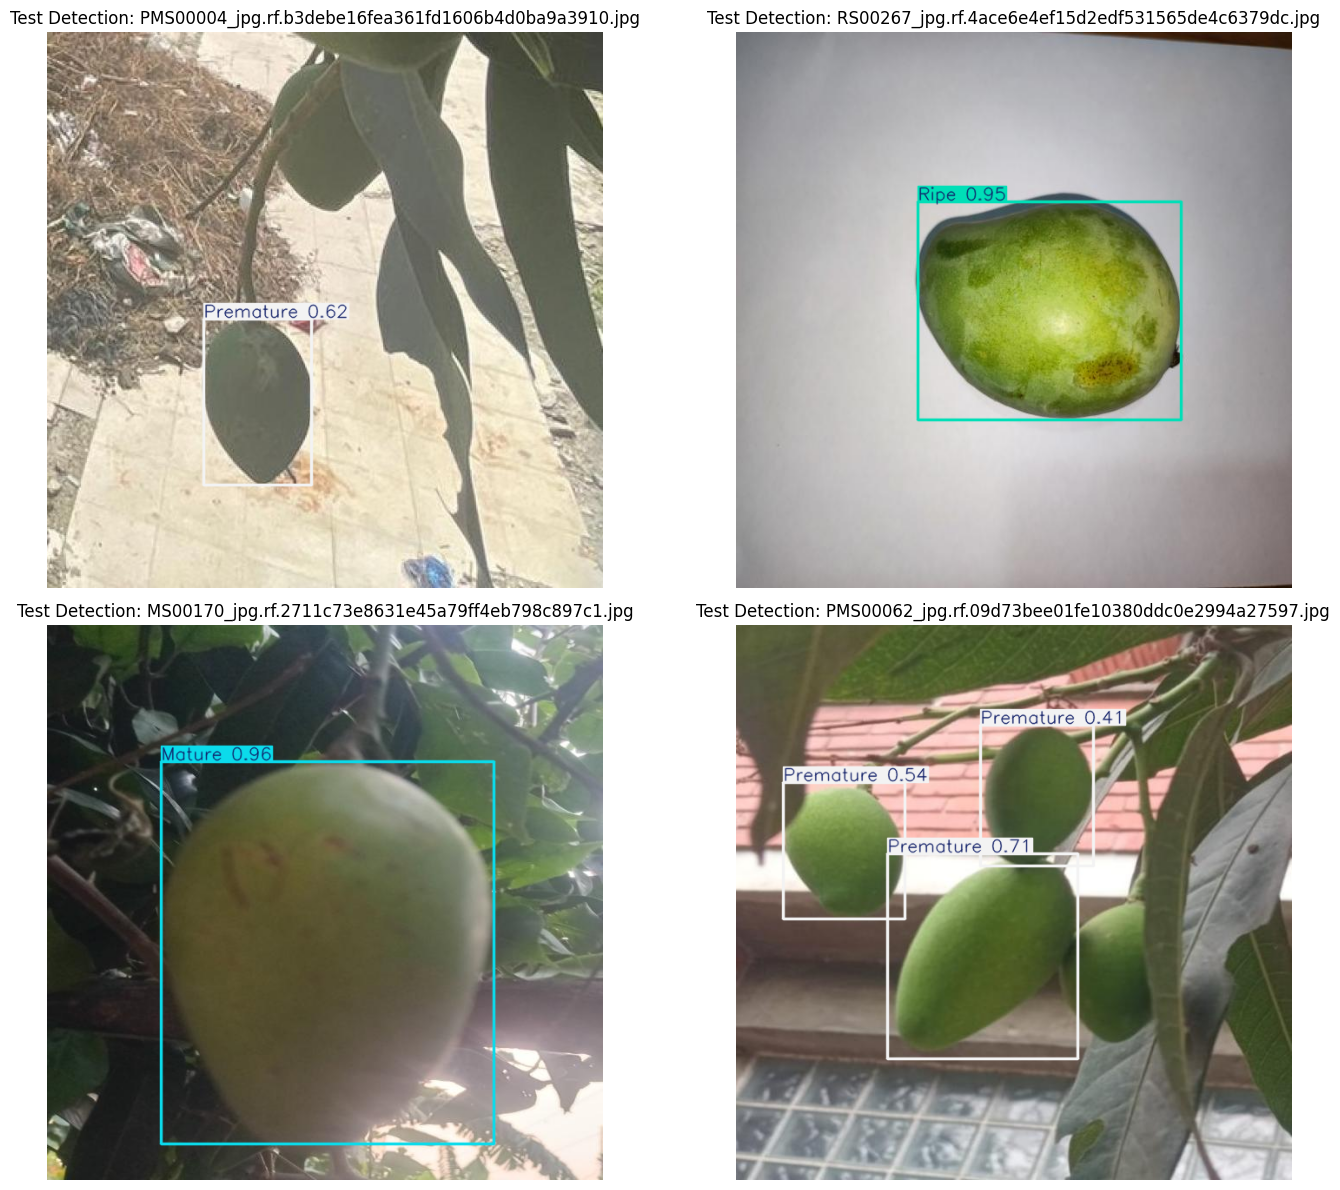

In [10]:
test_candidates = list((SPLIT/"test"/"images").glob("*.*"))
if test_candidates:
    # Visualize multiple test images
    n_viz = min(4, len(test_candidates))
    test_sample = random.sample(test_candidates, n_viz)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for idx, img_path in enumerate(test_sample):
        if idx >= len(axes):
            break

        print(f"\nTest Visualization {idx+1}: {img_path.name}")

        pred = model.predict(source=str(img_path), imgsz=640, conf=0.25,
                           device=0 if device=="cuda" else None, verbose=False)[0]

        axes[idx].imshow(pred.plot()[:,:,::-1])
        axes[idx].axis("off")
        axes[idx].set_title(f"Test Detection: {img_path.name}")

        # Print detection details
        if len(pred.boxes) > 0:
            print(f"Detected {len(pred.boxes)} objects:")
            class_names = ["Early-Fruit", "Mature", "Premature", "Ripe"]
            for box in pred.boxes:
                cls_id = int(box.cls[0])
                conf = float(box.conf[0])
                if cls_id < len(class_names):
                    print(f"  - {class_names[cls_id]}: {conf:.3f}")
        else:
            print("No objects detected")

    plt.tight_layout()
    plt.savefig(PLOTS / 'test_detections_v11.png', dpi=150, bbox_inches='tight')
    plt.show()


# SSL Feature Analysis and Visualization


BYOL Feature Analysis using /kaggle/working/mango_ssl_v11/byol_backbone_with_hooks_yv11.pth...
Loading data for feature analysis...
Train: 1600, Val: 199, Test: 201 images
Extracting BYOL features for analysis...


Extract train:   0%|          | 0/50 [00:00<?, ?it/s]

Extract val:   0%|          | 0/7 [00:00<?, ?it/s]

Extract test:   0%|          | 0/7 [00:00<?, ?it/s]

Feature shapes - Train: (1600, 448), Val: (199, 448), Test: (201, 448)

SSL Feature Quality (k-NN on TEST SET):
Test Accuracy: 0.5821
Test F1-Score: 0.5793

Classification Report (TEST SET):
              precision    recall  f1-score   support

 Early-Fruit       0.60      0.64      0.62        47
      Mature       0.43      0.52      0.47        52
   Premature       0.39      0.30      0.34        53
        Ripe       0.94      0.90      0.92        49

    accuracy                           0.58       201
   macro avg       0.59      0.59      0.59       201
weighted avg       0.58      0.58      0.58       201



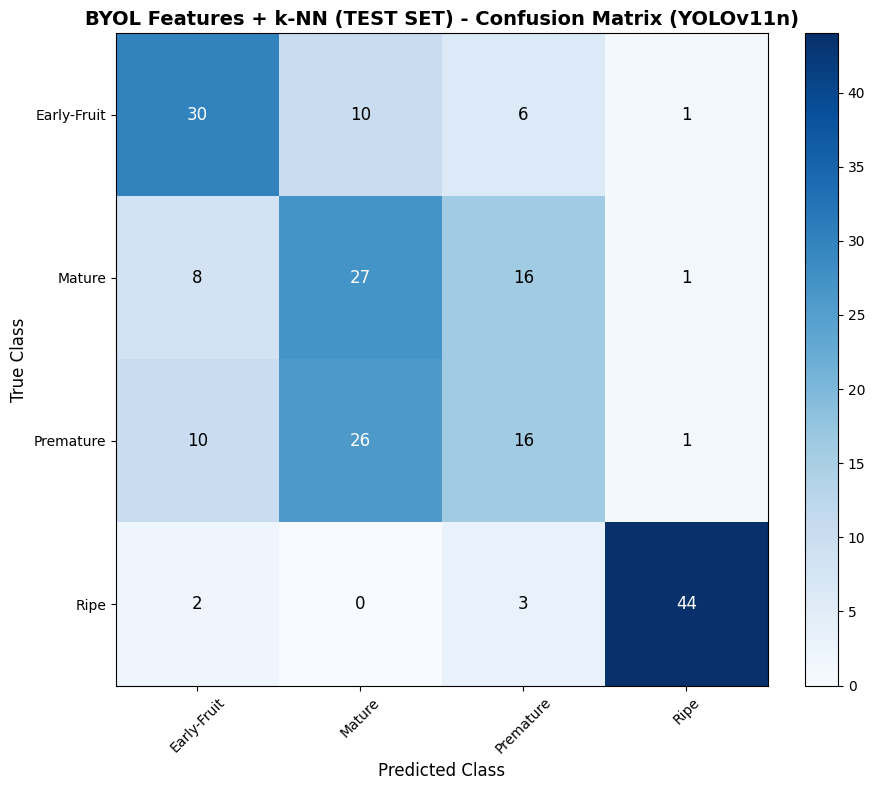

Creating t-SNE visualization for TEST SET...


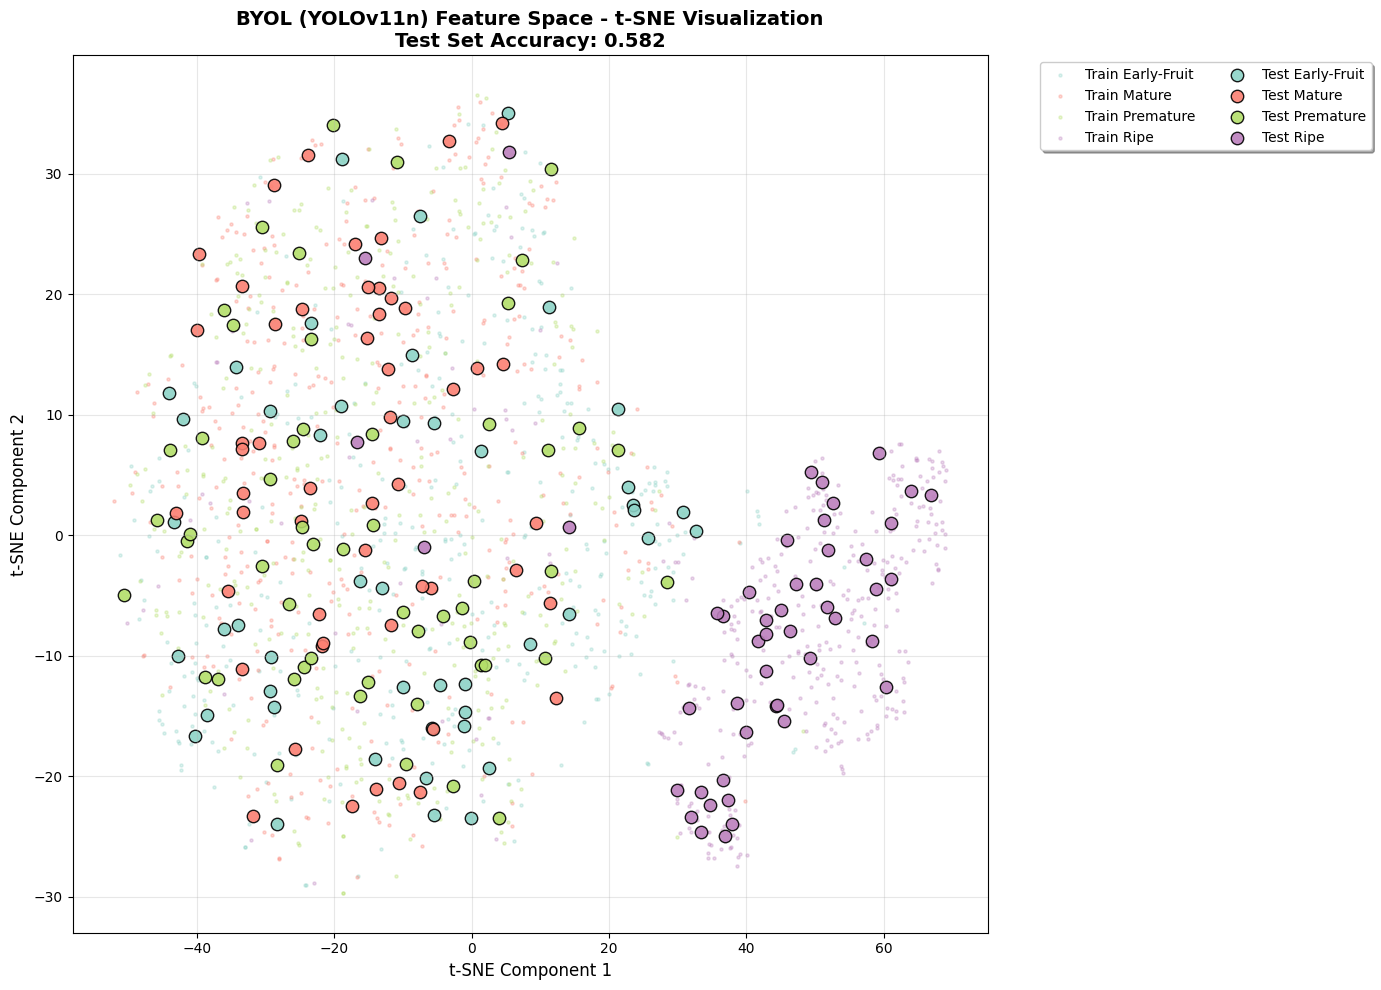

Creating PCA visualization for TEST SET...


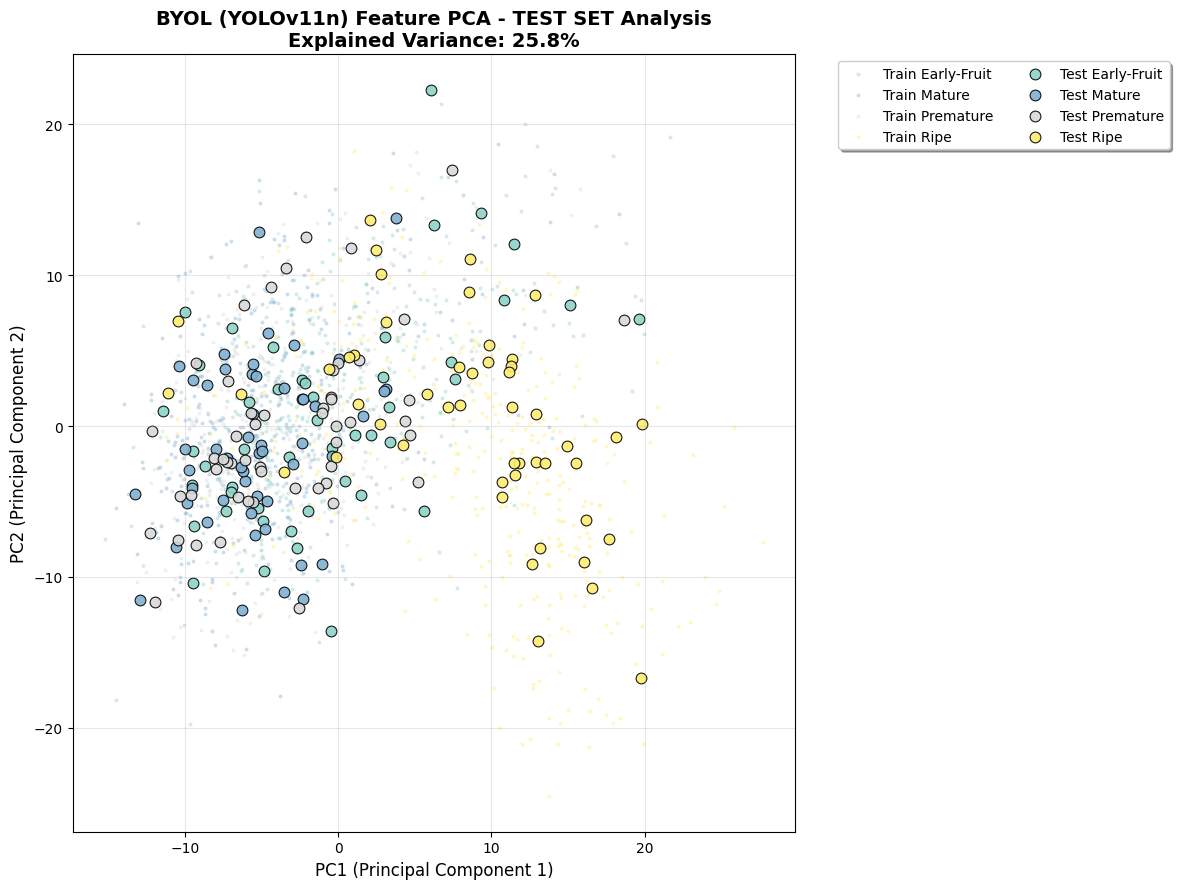

Analyzing feature quality and class separability...
Silhouette Score (TEST SET): 0.016

Class Centroid Analysis (TEST SET):
  Early-Fruit: Count=47, Centroid=(-0.926, 0.507)
  Mature: Count=52, Centroid=(-5.218, -1.343)
  Premature: Count=53, Centroid=(-3.237, -0.217)
  Ripe: Count=49, Centroid=(8.354, 0.391)

Inter-class Distance Analysis (TEST SET):
  Early-Fruit - Mature: 4.674
  Early-Fruit - Premature: 2.422
  Early-Fruit - Ripe: 9.280
  Mature - Premature: 2.279
  Mature - Ripe: 13.682
  Premature - Ripe: 11.607


In [11]:
def yolo_label_for_image(label_file: Path):
    if not label_file.exists():
        return None
    ids = []
    with open(label_file) as f:
        for line in f:
            parts = line.strip().split()
            if parts:
                try:
                    ids.append(int(parts[0]))
                except:
                    pass
    return max(ids, key=ids.count) if ids else None

def list_images_and_labels(split_dir: Path):
    xs, ys = [], []
    images = sorted((split_dir/"images").glob("*.*"))
    for img_path in images:
        lb_path = (split_dir/"labels"/(img_path.stem + ".txt"))
        lab = yolo_label_for_image(lb_path)
        if lab is None:
            continue
        xs.append(img_path)
        ys.append(lab)
    return xs, np.array(ys, dtype=np.int64)

if SSL_W.exists():
    print(f"\nBYOL Feature Analysis using {SSL_W}...")

    # Load SSL feature extractor
    feat_model = YOLO(MODEL).model.to(device)
    ssl_weights = torch.load(SSL_W, map_location="cpu")
    feat_model.load_state_dict(ssl_weights, strict=False)
    feat_hook = DetectInputHook(get_detect_module(feat_model))
    feat_model.eval()

    base_tfm = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    class ImgDataset(Dataset):
        def __init__(self, paths, tfm):
            self.paths = paths
            self.tfm = tfm
        def __len__(self):
            return len(self.paths)
        def __getitem__(self, i):
            return self.tfm(Image.open(self.paths[i]).convert("RGB"))

    def extract_feats(paths, bs=32, desc="Extract"):
        if not paths:
            return np.zeros((0, 1))

        ds = ImgDataset(paths, base_tfm)
        dl = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0, pin_memory=False)
        feats = []

        for xb in tqdm(dl, desc=desc, leave=False):
            xb = xb.to(device, non_blocking=True)
            with torch.no_grad():
                try:
                    _ = feat_model(xb)
                    h = global_pool_concat(feat_hook.feats)
                    feats.append(h.detach().cpu().numpy())
                except Exception as e:
                    print(f"Error extracting features: {e}")
                    continue

        return np.concatenate(feats, axis=0) if feats else np.zeros((0, 1))

    # Load data for all splits including TEST SET
    print("Loading data for feature analysis...")
    train_X, train_y = list_images_and_labels(SPLIT/"train")
    val_X, val_y = list_images_and_labels(SPLIT/"val")
    test_X, test_y = list_images_and_labels(SPLIT/"test")  # TEST SET

    print(f"Train: {len(train_X)}, Val: {len(val_X)}, Test: {len(test_X)} images")

    if len(train_X) > 0 and len(test_X) > 0:
        print("Extracting BYOL features for analysis...")
        train_F = extract_feats(train_X, bs=32, desc="Extract train")
        val_F = extract_feats(val_X, bs=32, desc="Extract val")
        test_F = extract_feats(test_X, bs=32, desc="Extract test")  # TEST SET FEATURES

        print(f"Feature shapes - Train: {train_F.shape}, Val: {val_F.shape}, Test: {test_F.shape}")

        if train_F.shape[0] > 0 and test_F.shape[0] > 0 and train_F.shape[1] > 1:

            # ================================================================
            # k-NN Classification on TEST SET (SSL Feature Quality)
            # ================================================================
            k = min(5, len(train_X))
            knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
            knn.fit(train_F, train_y)

            # Predict on TEST SET
            test_pred = knn.predict(test_F)
            test_acc = accuracy_score(test_y, test_pred)
            test_f1 = f1_score(test_y, test_pred, average='weighted')

            print(f"\nSSL Feature Quality (k-NN on TEST SET):")
            print(f"Test Accuracy: {test_acc:.4f}")
            print(f"Test F1-Score: {test_f1:.4f}")

            # Detailed classification report for TEST SET
            class_names = ["Early-Fruit", "Mature", "Premature", "Ripe"]
            print(f"\nClassification Report (TEST SET):")
            print(classification_report(test_y, test_pred,
                                      target_names=[class_names[i] for i in np.unique(test_y)]))

            # ================================================================
            # Confusion Matrix for TEST SET
            # ================================================================
            cm = confusion_matrix(test_y, test_pred)
            plt.figure(figsize=(10, 8))
            plt.imshow(cm, interpolation="nearest", cmap='Blues')
            plt.title("BYOL Features + k-NN (TEST SET) - Confusion Matrix (YOLOv11n)", fontsize=14, fontweight='bold')
            plt.xlabel("Predicted Class", fontsize=12)
            plt.ylabel("True Class", fontsize=12)
            plt.colorbar(fraction=0.046, pad=0.04)

            # Add text annotations
            thresh = cm.max() / 2.
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    plt.text(j, i, format(cm[i, j], 'd'),
                           ha="center", va="center", fontsize=12,
                           color="white" if cm[i, j] > thresh else "black")

            # Add class labels
            unique_classes = np.unique(test_y)
            if len(unique_classes) <= len(class_names):
                tick_marks = np.arange(len(unique_classes))
                plt.xticks(tick_marks, [class_names[i] for i in unique_classes], rotation=45)
                plt.yticks(tick_marks, [class_names[i] for i in unique_classes])

            plt.tight_layout()
            plt.savefig(PLOTS / 'test_confusion_matrix_v11.png', dpi=150, bbox_inches='tight')
            plt.show()

            # ================================================================
            # t-SNE Visualization with TEST SET
            # ================================================================
            if len(test_F) > 10:
                print("Creating t-SNE visualization for TEST SET...")

                # Combine train and test for better visualization
                combined_F = np.vstack([train_F, test_F])
                combined_y = np.hstack([train_y, test_y])
                combined_split = np.hstack([
                    np.zeros(len(train_y)),  # 0 for train
                    np.ones(len(test_y))     # 1 for test
                ])

                perplex = min(30, max(5, len(combined_F)//10))
                tsne = TSNE(n_components=2, init="pca", learning_rate="auto",
                           perplexity=perplex, max_iter=1000, random_state=42)
                Z = tsne.fit_transform(combined_F)

                # Split back
                train_Z = Z[combined_split == 0]
                test_Z = Z[combined_split == 1]

                plt.figure(figsize=(14, 10))

                # Plot training data (background, faint)
                for i, c in enumerate(np.unique(combined_y)):
                    train_idx = np.where((combined_y == c) & (combined_split == 0))[0]
                    if len(train_idx):
                        class_name = class_names[c] if c < len(class_names) else f"Class {c}"
                        plt.scatter(Z[train_idx, 0], Z[train_idx, 1],
                                   s=20, alpha=0.3, color=plt.cm.Set3(c/len(class_names)),
                                   label=f"Train {class_name}", marker='.')

                # Plot test data (emphasized)
                for i, c in enumerate(np.unique(combined_y)):
                    test_idx = np.where((combined_y == c) & (combined_split == 1))[0]
                    if len(test_idx):
                        class_name = class_names[c] if c < len(class_names) else f"Class {c}"
                        plt.scatter(Z[test_idx, 0], Z[test_idx, 1],
                                   s=80, alpha=0.9, color=plt.cm.Set3(c/len(class_names)),
                                   edgecolors='black', linewidths=1,
                                   marker='o', label=f"Test {class_name}")

                plt.title(f"BYOL (YOLOv11n) Feature Space - t-SNE Visualization\nTest Set Accuracy: {test_acc:.3f}",
                         fontsize=14, fontweight='bold')
                plt.xlabel("t-SNE Component 1", fontsize=12)
                plt.ylabel("t-SNE Component 2", fontsize=12)

                # Enhanced legend
                handles, labels = plt.gca().get_legend_handles_labels()
                plt.legend(handles, labels, fontsize=10, ncol=2,
                          frameon=True, fancybox=True, shadow=True,
                          bbox_to_anchor=(1.05, 1), loc='upper left')

                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.savefig(PLOTS / 'test_tsne_visualization_v11.png', dpi=200, bbox_inches='tight')
                plt.show()

            # ================================================================
            # PCA Visualization for TEST SET
            # ================================================================
            print("Creating PCA visualization for TEST SET...")

            # Standardize features
            scaler = StandardScaler()
            train_Fs = scaler.fit_transform(train_F)
            test_Fs = scaler.transform(test_F)

            # PCA
            pca = PCA(n_components=2, random_state=42)
            train_P = pca.fit_transform(train_Fs)
            test_P = pca.transform(test_Fs)

            evr = pca.explained_variance_ratio_.sum()

            plt.figure(figsize=(12, 9))
            classes = np.unique(np.concatenate([train_y, test_y]))
            colors = plt.cm.Set3(np.linspace(0, 1, len(classes)))

            # Plot training data (faint)
            for i, c in enumerate(classes):
                idx = np.where(train_y == c)[0]
                if len(idx):
                    class_name = class_names[c] if c < len(class_names) else f"Class {c}"
                    plt.scatter(train_P[idx, 0], train_P[idx, 1],
                               s=15, alpha=0.3, color=colors[i],
                               label=f"Train {class_name}", marker='.')

            # Plot TEST data (emphasized)
            for i, c in enumerate(classes):
                idx = np.where(test_y == c)[0]
                if len(idx):
                    class_name = class_names[c] if c < len(class_names) else f"Class {c}"
                    plt.scatter(test_P[idx, 0], test_P[idx, 1],
                               s=60, alpha=0.9, color=colors[i],
                               edgecolors='black', linewidths=0.8,
                               marker='o', label=f"Test {class_name}")

            plt.title(f"BYOL (YOLOv11n) Feature PCA - TEST SET Analysis\nExplained Variance: {evr*100:.1f}%",
                     fontsize=14, fontweight='bold')
            plt.xlabel("PC1 (Principal Component 1)", fontsize=12)
            plt.ylabel("PC2 (Principal Component 2)", fontsize=12)

            # Enhanced legend
            handles, labels = plt.gca().get_legend_handles_labels()
            uniq = dict(zip(labels, handles))
            plt.legend(uniq.values(), uniq.keys(), fontsize=10, ncol=2,
                      frameon=True, fancybox=True, shadow=True,
                      bbox_to_anchor=(1.05, 1), loc='upper left')

            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.savefig(PLOTS / 'test_pca_visualization_v11.png', dpi=200, bbox_inches='tight')
            plt.show()

            # ================================================================
            # Feature Quality Analysis
            # ================================================================
            print("Analyzing feature quality and class separability...")

            # Silhouette analysis on test set
            from sklearn.metrics import silhouette_score
            if len(np.unique(test_y)) > 1:
                test_sil_score = silhouette_score(test_F, test_y)
                print(f"Silhouette Score (TEST SET): {test_sil_score:.3f}")

            # Class centroid analysis
            print("\nClass Centroid Analysis (TEST SET):")
            for c in np.unique(test_y):
                class_name = class_names[c] if c < len(class_names) else f"Class {c}"
                test_class_mask = test_y == c
                if np.any(test_class_mask):
                    test_centroid = np.mean(test_P[test_class_mask], axis=0)
                    test_count = np.sum(test_class_mask)
                    print(f"  {class_name}: Count={test_count}, Centroid=({test_centroid[0]:.3f}, {test_centroid[1]:.3f})")

            # Inter-class distance analysis
            print("\nInter-class Distance Analysis (TEST SET):")
            test_centroids = []
            class_list = []
            for c in np.unique(test_y):
                test_class_mask = test_y == c
                if np.any(test_class_mask):
                    test_centroids.append(np.mean(test_P[test_class_mask], axis=0))
                    class_list.append(c)

            if len(test_centroids) > 1:
                test_centroids = np.array(test_centroids)
                from scipy.spatial.distance import pdist, squareform
                distances = squareform(pdist(test_centroids))

                for i, c1 in enumerate(class_list):
                    for j, c2 in enumerate(class_list):
                        if i < j:  # Only upper triangle
                            name1 = class_names[c1] if c1 < len(class_names) else f"Class {c1}"
                            name2 = class_names[c2] if c2 < len(class_names) else f"Class {c2}"
                            print(f"  {name1} - {name2}: {distances[i,j]:.3f}")

    # Cleanup
    feat_hook.close()
    del feat_model
    gc.collect()
    if device == "cuda":
        torch.cuda.empty_cache()

else:
    print(f"SSL weights not found at {SSL_W}")


# Training Loss Curves Compilation


Compiling Training Loss Curves...


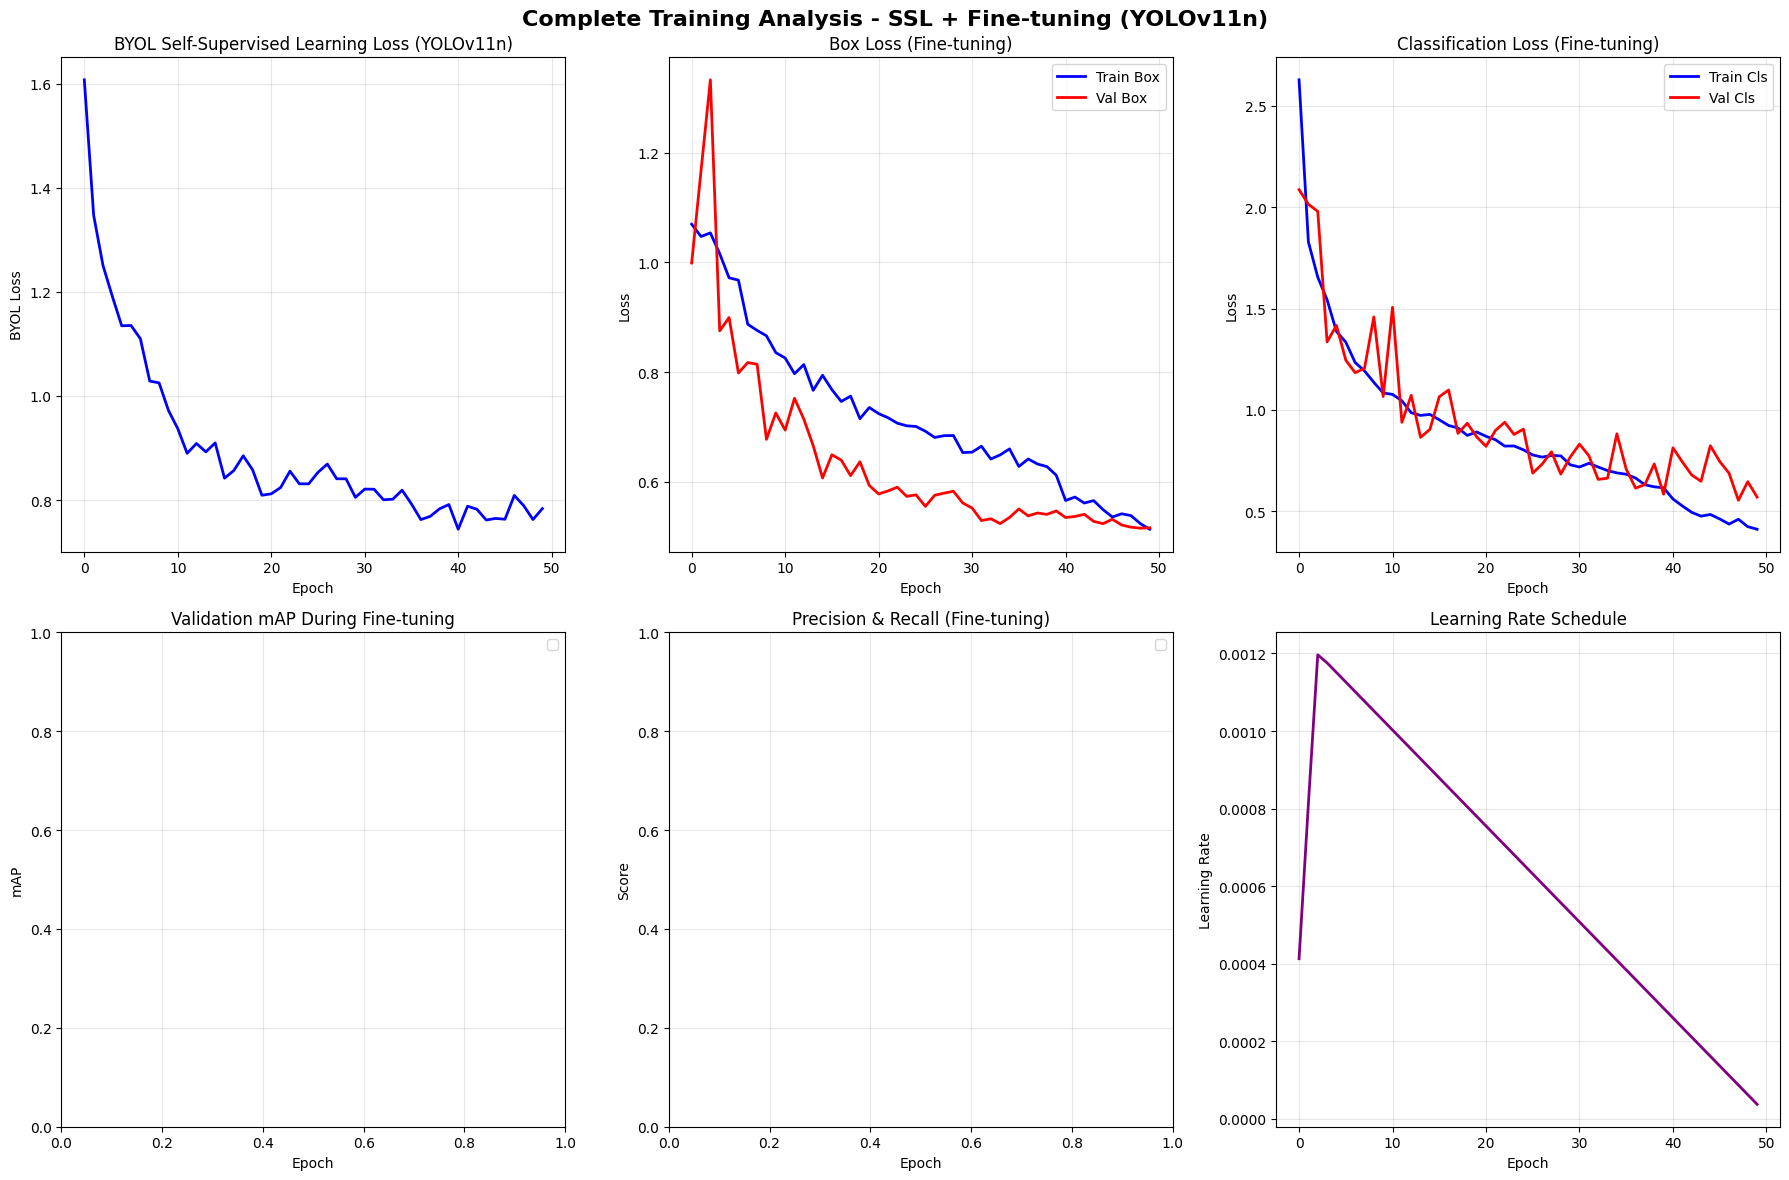

In [12]:
print("\nCompiling Training Loss Curves...")

# Create comprehensive training visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. SSL Training Loss
if (PLOTS / 'ssl_losses_v11.npy').exists():
    ssl_losses = np.load(PLOTS / 'ssl_losses_v11.npy')

    axes[0,0].plot(ssl_losses, 'b-', linewidth=2)
    axes[0,0].set_title('BYOL Self-Supervised Learning Loss (YOLOv11n)')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('BYOL Loss')
    axes[0,0].grid(True, alpha=0.3)
else:
    axes[0,0].text(0.5, 0.5, 'SSL Loss\nNot Available',
                   ha='center', va='center', transform=axes[0,0].transAxes)
    axes[0,0].set_title('SSL Training Loss (Not Available)')

# 2. Fine-tuning Loss (from YOLO training results)
ft_results_dir = WORK / "byol_yolov11n_mango_final"
ft_loss_file = ft_results_dir / "results.csv"

if ft_loss_file.exists():
    import pandas as pd
    ft_results = pd.read_csv(ft_loss_file)

    # Box Loss
    if 'train/box_loss' in ft_results.columns:
        axes[0,1].plot(ft_results['train/box_loss'], 'b-', label='Train Box', linewidth=2)
    if 'val/box_loss' in ft_results.columns:
        axes[0,1].plot(ft_results['val/box_loss'], 'r-', label='Val Box', linewidth=2)
    axes[0,1].set_title('Box Loss (Fine-tuning)')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Classification Loss
    if 'train/cls_loss' in ft_results.columns:
        axes[0,2].plot(ft_results['train/cls_loss'], 'b-', label='Train Cls', linewidth=2)
    if 'val/cls_loss' in ft_results.columns:
        axes[0,2].plot(ft_results['val/cls_loss'], 'r-', label='Val Cls', linewidth=2)
    axes[0,2].set_title('Classification Loss (Fine-tuning)')
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Loss')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # mAP metrics
    if 'val/mAP50' in ft_results.columns:
        axes[1,0].plot(ft_results['val/mAP50'], 'g-', label='mAP@0.5', linewidth=2)
    if 'val/mAP50-95' in ft_results.columns:
        axes[1,0].plot(ft_results['val/mAP50-95'], 'purple', label='mAP@0.5:0.95', linewidth=2)
    axes[1,0].set_title('Validation mAP During Fine-tuning')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('mAP')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Precision and Recall
    if 'precision(B)' in ft_results.columns:
        axes[1,1].plot(ft_results['precision(B)'], 'orange', label='Precision', linewidth=2)
    if 'recall(B)' in ft_results.columns:
        axes[1,1].plot(ft_results['recall(B)'], 'red', label='Recall', linewidth=2)
    axes[1,1].set_title('Precision & Recall (Fine-tuning)')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Score')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # Learning Rate
    if 'lr/pg0' in ft_results.columns:
        axes[1,2].plot(ft_results['lr/pg0'], 'purple', linewidth=2)
    elif 'lr' in ft_results.columns:
        axes[1,2].plot(ft_results['lr'], 'purple', linewidth=2)
    axes[1,2].set_title('Learning Rate Schedule')
    axes[1,2].set_xlabel('Epoch')
    axes[1,2].set_ylabel('Learning Rate')
    axes[1,2].grid(True, alpha=0.3)

else:
    print(f"Fine-tuning results not found at {ft_loss_file}")

    # Fill empty plots with messages
    for i, j in [(0,1), (0,2), (1,0), (1,1), (1,2)]:
        axes[i,j].text(0.5, 0.5, 'Fine-tuning data\nnot available',
                      ha='center', va='center', transform=axes[i,j].transAxes)
        axes[i,j].set_title(f'Fine-tuning Metrics (Not Available)')

plt.suptitle('Complete Training Analysis - SSL + Fine-tuning (YOLOv11n)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS / 'complete_training_analysis_v11.png', dpi=150, bbox_inches='tight')
plt.show()

# Additional Comprehensive Evaluation on TEST SET


Additional TEST SET Analysis...
Test Set Statistics:
  Total test images: 201
  Total test labels: 201

Test Set Class Distribution:
  Premature: 86 detections
  Mature: 94 detections
  Ripe: 52 detections
  Early-Fruit: 78 detections


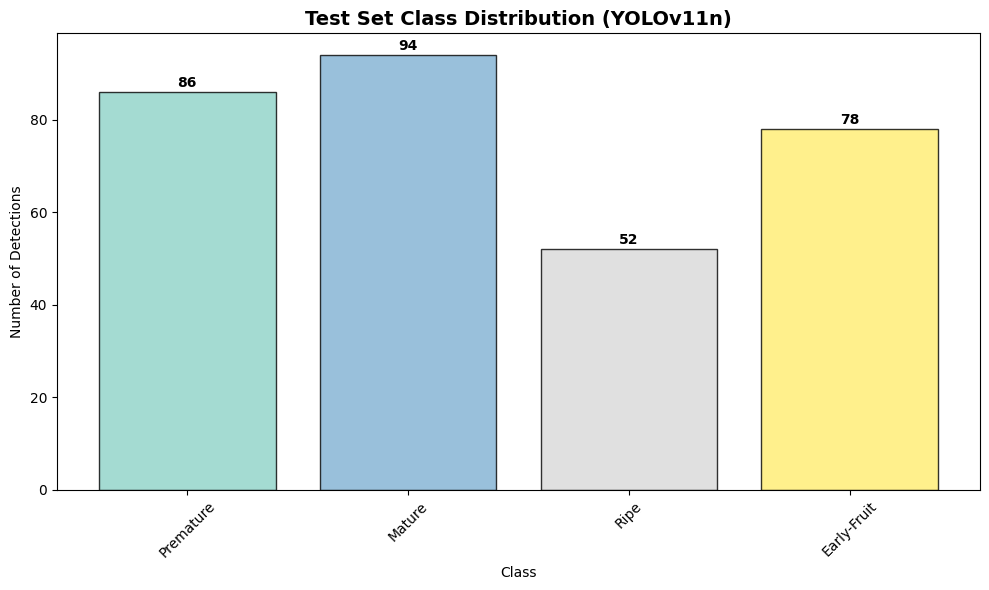

In [13]:
print("\nAdditional TEST SET Analysis...")

# Test set size analysis
if (SPLIT/"test"/"images").exists():
    test_images_list = list((SPLIT/"test"/"images").glob("*.*"))
    test_labels_list = list((SPLIT/"test"/"labels").glob("*.txt"))

    print(f"Test Set Statistics:")
    print(f"  Total test images: {len(test_images_list)}")
    print(f"  Total test labels: {len(test_labels_list)}")

    # Class distribution in test set
    test_class_counts = {}
    class_names = ["Early-Fruit", "Mature", "Premature", "Ripe"]

    for label_file in test_labels_list:
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    try:
                        class_id = int(parts[0])
                        class_name = class_names[class_id] if class_id < len(class_names) else f"Class_{class_id}"
                        test_class_counts[class_name] = test_class_counts.get(class_name, 0) + 1
                    except:
                        pass

    print(f"\nTest Set Class Distribution:")
    for class_name, count in test_class_counts.items():
        print(f"  {class_name}: {count} detections")

    # Visualize class distribution
    if test_class_counts:
        plt.figure(figsize=(10, 6))
        classes = list(test_class_counts.keys())
        counts = list(test_class_counts.values())
        colors = plt.cm.Set3(np.linspace(0, 1, len(classes)))

        bars = plt.bar(classes, counts, color=colors, alpha=0.8, edgecolor='black')
        plt.title('Test Set Class Distribution (YOLOv11n)', fontsize=14, fontweight='bold')
        plt.xlabel('Class')
        plt.ylabel('Number of Detections')
        plt.xticks(rotation=45)

        # Add count labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    str(count), ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.savefig(PLOTS / 'test_class_distribution_v11.png', dpi=150, bbox_inches='tight')
        plt.show()


# FINAL COMPREHENSIVE SUMMARY FOR REPORT


FINAL PROJECT REPORT SUMMARY (YOLOv11n)

FINAL TEST SET PERFORMANCE METRICS (YOLOv11n):
  Model         : YOLOv11n
  SSL Method    : BYOL
  Precision     : 0.8524
  Recall        : 0.8386
  F1-Score      : 0.8454
  mAP@0.5       : 0.9123
  mAP@0.5:0.95  : 0.8226
  All metrics calculated on TEST SET (not validation)

GENERATED VISUALIZATIONS FOR FINAL REPORT:
  SSL Training Loss Curve (YOLOv11n)
  Complete Training Loss Curves (YOLOv11n)
  Test Set Confusion Matrix (YOLOv11n)
  Test Set t-SNE Feature Visualization (YOLOv11n)
  Test Set PCA Feature Visualization (YOLOv11n)
  Test Set Detection Examples (YOLOv11n)
  Test Set Class Distribution (YOLOv11n)

Output Locations:
  Visualizations: /kaggle/working/mango_ssl_v11/plots
  Model weights: /kaggle/working/mango_ssl_v11
  Dataset: /kaggle/working/mango_ssl_v11/0_yolo_split

SUMMARY (YOLOv11n):
  - SSL Method: BYOL (Bootstrap Your Own Latent)
  - Backbone: YOLOv11-n with Detect head hooks
  - SSL Epochs: 50
  - Fine-tuning Epochs: 50
  

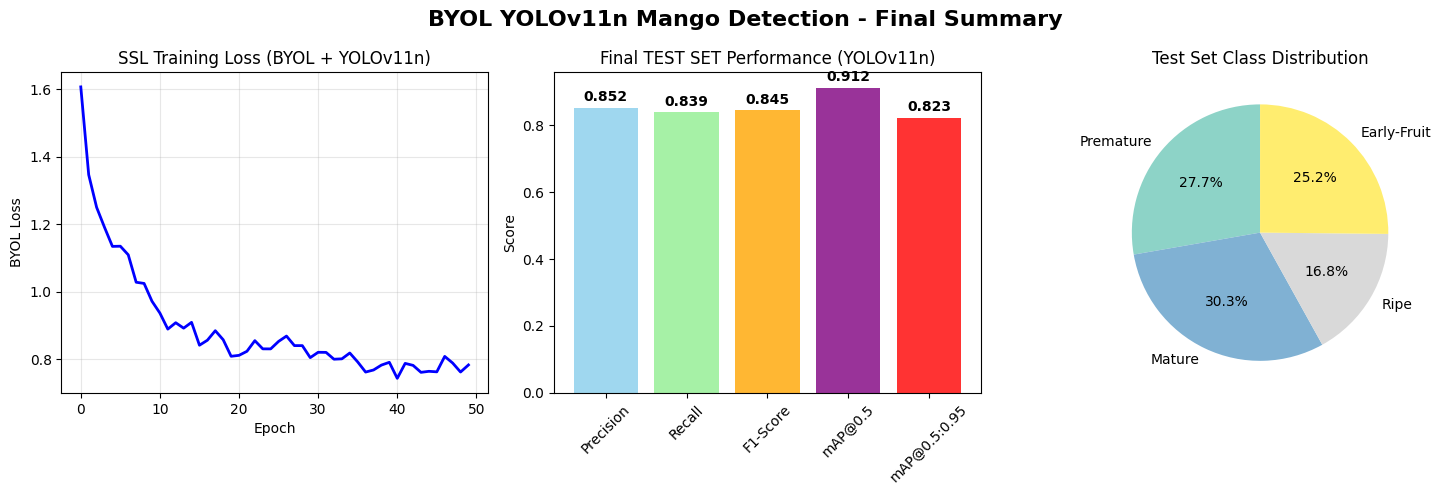

In [14]:
print("\n" + "="*60)
print("FINAL PROJECT REPORT SUMMARY (YOLOv11n)")
print("="*60)

# Load and display test metrics
test_metrics_file = PLOTS / 'test_metrics_v11.json'
if test_metrics_file.exists():
    with open(test_metrics_file, 'r') as f:
        metrics = json.load(f)

    print("\nFINAL TEST SET PERFORMANCE METRICS (YOLOv11n):")
    print(f"  Model         : {metrics['model']}")
    print(f"  SSL Method    : {metrics['ssl_method']}")
    print(f"  Precision     : {metrics['precision']:.4f}")
    print(f"  Recall        : {metrics['recall']:.4f}")
    print(f"  F1-Score      : {metrics['f1_score']:.4f}")
    print(f"  mAP@0.5       : {metrics['map_50']:.4f}")
    print(f"  mAP@0.5:0.95  : {metrics['map_50_95']:.4f}")
    print("  All metrics calculated on TEST SET (not validation)")

print("\nGENERATED VISUALIZATIONS FOR FINAL REPORT:")
required_files_v11 = [
    ('byol_ssl_training_curve_v11.png', 'SSL Training Loss Curve (YOLOv11n)'),
    ('complete_training_analysis_v11.png', 'Complete Training Loss Curves (YOLOv11n)'),
    ('test_confusion_matrix_v11.png', 'Test Set Confusion Matrix (YOLOv11n)'),
    ('test_tsne_visualization_v11.png', 'Test Set t-SNE Feature Visualization (YOLOv11n)'),
    ('test_pca_visualization_v11.png', 'Test Set PCA Feature Visualization (YOLOv11n)'),
    ('test_detections_v11.png', 'Test Set Detection Examples (YOLOv11n)'),
    ('test_class_distribution_v11.png', 'Test Set Class Distribution (YOLOv11n)')
]

all_files_exist = True
for filename, description in required_files_v11:
    filepath = PLOTS / filename
    if filepath.exists():
        print(f"  {description}")
    else:
        print(f"  {description} - Not generated")
        all_files_exist = False

print(f"\nOutput Locations:")
print(f"  Visualizations: {PLOTS}")
print(f"  Model weights: {WORK}")
print(f"  Dataset: {SPLIT}")

print(f"\nSUMMARY (YOLOv11n):")
print(f"  - SSL Method: BYOL (Bootstrap Your Own Latent)")
print(f"  - Backbone: YOLOv11-n with Detect head hooks")
print(f"  - SSL Epochs: {SSL_EPOCHS}")
print(f"  - Fine-tuning Epochs: 50")
print(f"  - Dataset: Mango (4 classes: Early-Fruit, Mature, Premature, Ripe)")
print(f"  - Evaluation: Comprehensive TEST SET analysis")
print(f"  - All files saved to: {WORK}")

# Create a final summary plot combining key metrics
plt.figure(figsize=(15, 5))

# SSL Loss
plt.subplot(1, 3, 1)
if (PLOTS / 'ssl_losses_v11.npy').exists():
    ssl_losses = np.load(PLOTS / 'ssl_losses_v11.npy')
    plt.plot(ssl_losses, 'b-', linewidth=2)
    plt.title('SSL Training Loss (BYOL + YOLOv11n)')
    plt.xlabel('Epoch')
    plt.ylabel('BYOL Loss')
    plt.grid(True, alpha=0.3)

# Test metrics bar chart
plt.subplot(1, 3, 2)
if test_metrics_file.exists():
    with open(test_metrics_file, 'r') as f:
        metrics = json.load(f)

    metric_names = ['Precision', 'Recall', 'F1-Score', 'mAP@0.5', 'mAP@0.5:0.95']
    metric_values = [metrics['precision'], metrics['recall'], metrics['f1_score'],
                    metrics['map_50'], metrics['map_50_95']]

    bars = plt.bar(metric_names, metric_values, alpha=0.8,
                   color=['skyblue', 'lightgreen', 'orange', 'purple', 'red'])
    plt.title('Final TEST SET Performance (YOLOv11n)')
    plt.ylabel('Score')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, metric_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Test class distribution
plt.subplot(1, 3, 3)
if 'test_class_counts' in locals() and test_class_counts:
    classes = list(test_class_counts.keys())
    counts = list(test_class_counts.values())
    colors = plt.cm.Set3(np.linspace(0, 1, len(classes)))

    plt.pie(counts, labels=classes, autopct='%1.1f%%', colors=colors, startangle=90)
    plt.title('Test Set Class Distribution')

plt.suptitle('BYOL YOLOv11n Mango Detection - Final Summary', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(PLOTS / 'final_summary_dashboard_v11.png', dpi=150, bbox_inches='tight')
plt.show()


